# IRS Migration Flows

This notebook pulls data from the IRS Migration database and compares inflows, outflows, and netflows for domestic migration between New York City and counties throughout the US, and the New York Metropolitan Area and metros throughout the US, over of period of several years.

Database: https://www.baruch.cuny.edu/confluence/display/geoportal/IRS+Migration+Database

## Modules, Variables, Functions

In [1]:
%matplotlib inline
import pandas as pd
import math
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors
import numpy as np
import sqlite3
import os
import pandas.io.formats.format as pf
plt.style.use ('seaborn-whitegrid')

# display numbers (floats) with thousand separator
pd.options.display.float_format = '{:,.0f}'.format

# found this hack to format integers for display with thousand separator
# https://stackoverflow.com/questions/29663252/format-pandas-integers-for-display?answertab=active#tab-top
class IntArrayFormatter(pf.GenericArrayFormatter):
    def _format_strings(self):
        formatter = self.formatter or '{:,d}'.format
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values
pf.IntArrayFormatter = IntArrayFormatter

In [2]:
# define paths and variables
dir_path = os.getcwd()
data_path=os.path.join(dir_path,'source_data')
out_path=os.path.join(dir_path,'output')
metro_file='counties_metros_2019.csv' # File is generated from metro_county_list.py
db='irs_migration_county.sqlite'

con = sqlite3.connect (os.path.join (data_path, db))
cur=con.cursor()
metros = pd.read_csv (os.path.join (data_path, metro_file),
                      converters={'ccode': str, 'mcode': str},encoding='latin1')
# project years
years = ('2011_12', '2012_13', '2013_14', '2014_15', '2015_16', '2016_17', '2017_18')  

# NYC counties
nyc = ('36005', '36047', '36061', '36081', '36085')

# NY Metro Counties
nyma=('34003','34013','34017','34019','34023','34025','34027','34029','34031',\
      '34035','34037','34039','36005','36047','36059','36061',\
      '36079','36081','36085','36087','36103','36119','42103')

# county fips and city names - counties home to the 10 largest cities in the US, population > 1 million
big_cities={'06037':'Los Angeles Co, CA','17031': 'Cook Co, IL (Chicago)','48201': 'Harris Co, TX (Houston)',
   '04013': 'Maricopa Co, AZ (Phoenix)','42101': 'Philadelphia Co, PA', '48029': 'Bexar Co, TX (San Antonio)', '06073': 'San Diego Co, CA',
  '48113': 'Dallas Co, TX', '06085': 'Santa Clara Co, CA (San Jose)','36005':'New York City, NY','36047':'New York City, NY',
       '36061':'New York City, NY','36081':'New York City, NY','36085':'New York City, NY'}

# cbsa codes for 14 biggest metros, population > 4 million
big_metros=['35620','31080','16980','19100','26420','47900','33100','37980','12060','38060','14460','41860','40140','19820']

# codes for foreign migration
foreign=('57005','57009','57001','57003','57007')

# codes for suppressed flows
suppressed=('58000','59000')
msuppressed=('0','58','59')

# plots colors
#wccolors=['#98d669','#73a6dc','#e4e2e1']
wccolors=['#59c134','#2250a9','#e4e2e1']

In [3]:
# TEST - look at one year of the inflow data in the database
inflow_temp = pd.read_sql_query ("SELECT * from inflow_2011_12", con)
inflow_temp.head()

,uid,st_dest_abbrv,destination,origin,st_orig_abbrv,co_orig_name,returns,exemptions,income,disclosure
0,01001_01001,AL,01001,01001,AL,Autauga County Non-migrants,"17,696","41,757","971,428",nan
1,01001_01051,AL,01001,01051,AL,Elmore County,466,"1,016","18,398",nan
2,01001_01101,AL,01001,01101,AL,Montgomery County,443,982,"15,955",nan
3,01001_01021,AL,01001,01021,AL,Chilton County,72,192,"2,228",nan
4,01001_01047,AL,01001,01047,AL,Dallas County,52,126,"1,638",nan


In [4]:
def get_flows_by_city(year, city):
    """ function to read in data from the database
    and combine flows for places of ineterest

    :rtype: dataframe"""

    # read in inflow & outflow data and store it in a pandas dataframe
    table1 = 'outflow_{}'.format (year)
    table2 = 'inflow_{}'.format (year)

    # SQL query to select 
    # flows between, but not within counties
    df_out = pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table1, table1, table1), con)
    df_in = pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table2, table2, table2), con)
    
    # most of the records for inflow will appear in the outflow table as well
    # and be same in both tables
    # make the uid be same for same records and set it as dataframe's index
    df_out['uid'] = df_out.origin + "_" + df_out.destination
    df_in['uid'] = df_in.origin + "_" + df_in.destination

    df_in.set_index ('uid', inplace=True)
    df_out.set_index ('uid', inplace=True)
    
    # select a subset of records between and not within selected counties
    city_in = df_in[(df_in['destination'].isin (city)) & (~df_in['origin'].isin (city))]
    city_out = df_out[(df_out['origin'].isin (city)) & (~df_out['destination'].isin (city))]
      
    to_city = city_in[['origin', 'co_orig_name', 'exemptions', 'st_orig_abbrv']].groupby (
        ['origin', 'co_orig_name', 'st_orig_abbrv']).sum().sort_values ('exemptions', ascending=False).reset_index ()
    
    from_city = city_out[['destination', 'co_dest_name', 'st_dest_abbrv', 'exemptions']].groupby (
        ['destination', 'co_dest_name', 'st_dest_abbrv']).sum().sort_values ('exemptions',
                                                                              ascending=False).reset_index ()
    
    to_city.rename (columns={'origin': 'co_fips', 'co_orig_name': 'co_name', 'exemptions': 'inflow' + year,
                             'st_orig_abbrv': 'state'}, inplace=True)
    
    from_city.rename (columns={'destination': 'co_fips', 'co_dest_name': 'co_name', 'st_dest_abbrv': 'state',
                               'exemptions': 'outflow' + year}, inplace=True)

    flows_city = to_city.merge (from_city, on=['co_fips', 'co_name', 'state'], how='outer')
    flows_city.fillna(0, inplace=True)

    # merge metro areas info to selected counties flows
    flows_city = flows_city.merge (metros[['mcode', 'mname', 'ccode']], left_on='co_fips', right_on='ccode',how='left').drop('ccode',1)
    
    # label counties that are not part of the metro areas and are not supressed or foreign as 'non-metro' counties
    flows_city.loc[(~flows_city['co_fips'].isin(suppressed)) & (~flows_city['co_fips'].isin(foreign)) & (flows_city['mcode'].isnull()),['mname']]='non-metro'
    flows_city.loc[(flows_city['mname']=='non-metro'),['mcode']]='0'
    
    # label suppressed flows for metro areas so they don't vanish when grouping and summing totals
    flows_city.loc[(flows_city['co_fips'].isin(suppressed)) & (~flows_city['co_fips'].isin(foreign)) & (flows_city['mcode'].isnull()),['mcode']]=flows_city['co_fips'].str[0:2]
    flows_city.loc[(flows_city['mcode'].isin(['58','59'])),['mname']]=flows_city['co_name']
    
    # Add state code to county name
    flows_city.loc[(~flows_city['co_fips'].isin(suppressed)) & (~flows_city['co_fips'].isin(foreign)),
               ['co_name']]=flows_city['co_name']+', '+flows_city['state']

    # add calculated columns
    flows_city['netflow' + year] = flows_city['inflow' + year] - flows_city['outflow' + year]

    return flows_city

## Read in Data and Prep

In [5]:
# empty lists to hold dataframes for each year
city_flows_dfs = []
metro_flows_dfs = []

In [6]:
# run the functions to get inflow/outflow data for New York city and for NY metro area
# for each year and append the results to a list
for year in years:
    city_flows_dfs.append (get_flows_by_city (year, nyc))

for year in years:
    metro_flows_dfs.append (get_flows_by_city (year, nyma))

# merge all years dfs for NYC (Metro) from the list into a single df
city_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'mcode', 'mname'], how='outer'), city_flows_dfs)
metro_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'mcode', 'mname'], how='outer'), metro_flows_dfs)

In [7]:
# Convert all flow columns to integers, must fill with zeros first
cols_to_int={c: 'int64' for c in city_flows.columns if c[-4].isdigit()}
for k in cols_to_int.keys():
    city_flows[k].fillna(0, inplace=True)
city_flows=city_flows.astype(cols_to_int)
city_flows.head()

,co_fips,co_name,state,inflow2011_12,outflow2011_12,mcode,mname,netflow2011_12,inflow2012_13,outflow2012_13,...,netflow2014_15,inflow2015_16,outflow2015_16,netflow2015_16,inflow2016_17,outflow2016_17,netflow2016_17,inflow2017_18,outflow2017_18,netflow2017_18
0,36059,"Nassau County, NY",NY,"13,995","22,803",35620,"New York-Newark-Jersey City, NY-NJ-PA","-8,808","14,458","24,494",...,"-8,416","12,884","26,345","-13,461","15,446","35,921","-20,475","14,062","30,584","-16,522"
1,59000,Other flows - Different State,DS,"13,850","16,808",59,Other flows - Different State,"-2,958","14,062","17,381",...,"-4,064","19,539","25,100","-5,561","19,978","27,303","-7,325","20,162","23,926","-3,764"
2,36119,"Westchester County, NY",NY,"11,588","16,967",35620,"New York-Newark-Jersey City, NY-NJ-PA","-5,379","10,806","18,414",...,"-4,938","9,771","18,833","-9,062","11,157","25,211","-14,054","9,902","19,826","-9,924"
3,36103,"Suffolk County, NY",NY,"8,838","9,785",35620,"New York-Newark-Jersey City, NY-NJ-PA",-947,"7,493","9,636",...,"-2,334","6,593","9,608","-3,015","7,366","13,228","-5,862","6,907","11,997","-5,090"
4,34017,"Hudson County, NJ",NJ,"6,308","8,761",35620,"New York-Newark-Jersey City, NY-NJ-PA","-2,453","6,270","9,141",...,"-2,564","5,282","9,862","-4,580","6,572","13,901","-7,329","5,990","11,474","-5,484"


In [8]:
# Re-order columns so flows are together
first_cols=['co_fips','co_name','state','mcode','mname']
reorder_cols=first_cols+[c for c in city_flows.columns if c not in first_cols]
city_flows=city_flows[reorder_cols]
city_flows.head()

,co_fips,co_name,state,mcode,mname,inflow2011_12,outflow2011_12,netflow2011_12,inflow2012_13,outflow2012_13,...,netflow2014_15,inflow2015_16,outflow2015_16,netflow2015_16,inflow2016_17,outflow2016_17,netflow2016_17,inflow2017_18,outflow2017_18,netflow2017_18
0,36059,"Nassau County, NY",NY,35620,"New York-Newark-Jersey City, NY-NJ-PA","13,995","22,803","-8,808","14,458","24,494",...,"-8,416","12,884","26,345","-13,461","15,446","35,921","-20,475","14,062","30,584","-16,522"
1,59000,Other flows - Different State,DS,59,Other flows - Different State,"13,850","16,808","-2,958","14,062","17,381",...,"-4,064","19,539","25,100","-5,561","19,978","27,303","-7,325","20,162","23,926","-3,764"
2,36119,"Westchester County, NY",NY,35620,"New York-Newark-Jersey City, NY-NJ-PA","11,588","16,967","-5,379","10,806","18,414",...,"-4,938","9,771","18,833","-9,062","11,157","25,211","-14,054","9,902","19,826","-9,924"
3,36103,"Suffolk County, NY",NY,35620,"New York-Newark-Jersey City, NY-NJ-PA","8,838","9,785",-947,"7,493","9,636",...,"-2,334","6,593","9,608","-3,015","7,366","13,228","-5,862","6,907","11,997","-5,090"
4,34017,"Hudson County, NJ",NJ,35620,"New York-Newark-Jersey City, NY-NJ-PA","6,308","8,761","-2,453","6,270","9,141",...,"-2,564","5,282","9,862","-4,580","6,572","13,901","-7,329","5,990","11,474","-5,484"


In [9]:
# ungrouped county-level flows for metro areas
for k in cols_to_int.keys():
    metro_flows[k].fillna(0, inplace=True)
metro_flows=metro_flows.astype(cols_to_int)
metro_flows.head()

,co_fips,co_name,state,inflow2011_12,outflow2011_12,mcode,mname,netflow2011_12,inflow2012_13,outflow2012_13,...,netflow2014_15,inflow2015_16,outflow2015_16,netflow2015_16,inflow2016_17,outflow2016_17,netflow2016_17,inflow2017_18,outflow2017_18,netflow2017_18
0,59000,Other flows - Different State,DS,"48,254","59,083",59,Other flows - Different State,"-10,829","49,137","60,188",...,"-17,940","65,648","89,912","-24,264","74,619","100,396","-25,777","68,261","87,702","-19,441"
1,09001,"Fairfield County, CT",CT,"6,853","11,130",14860,"Bridgeport-Stamford-Norwalk, CT","-4,277","7,374","12,111",...,"-3,668","7,155","12,330","-5,175","8,309","17,577","-9,268","7,591","14,167","-6,576"
2,12086,"Miami-Dade County, FL",FL,"6,829","7,676",33100,"Miami-Fort Lauderdale-Pompano Beach, FL",-847,"6,642","6,784",...,"-1,775","3,670","6,475","-2,805","4,741","7,223","-2,482","3,970","5,981","-2,011"
3,06037,"Los Angeles County, CA",CA,"6,707","9,010",31080,"Los Angeles-Long Beach-Anaheim, CA","-2,303","6,779","10,857",...,"-2,966","6,728","11,929","-5,201","8,276","15,286","-7,010","6,797","12,297","-5,500"
4,12011,"Broward County, FL",FL,"5,828","7,570",33100,"Miami-Fort Lauderdale-Pompano Beach, FL","-1,742","5,773","7,545",...,"-2,473","3,378","7,723","-4,345","4,350","9,102","-4,752","3,834","7,315","-3,481"


In [10]:
# get subsets of domestic and foreign flows separately
domestic_city_flows=city_flows[~city_flows['co_fips'].isin (foreign)].set_index('co_fips').copy()
foreign_city_flows=city_flows[city_flows['co_fips'].isin (foreign)].set_index('co_fips').copy()

domestic_metro_flows=metro_flows[~metro_flows['co_fips'].isin (foreign)].copy()
foreign_metro_flows=metro_flows[metro_flows['co_fips'].isin (foreign)].copy()

In [11]:
# group NYMA county-level flows by metro area to get metro-level flows for NYMA
grouped_by_metro=domestic_metro_flows.groupby(['mcode','mname']).sum().reset_index()
grouped_by_metro=grouped_by_metro.set_index('mcode')
grouped_by_metro.head()

,mname,inflow2011_12,outflow2011_12,netflow2011_12,inflow2012_13,outflow2012_13,netflow2012_13,inflow2013_14,outflow2013_14,netflow2013_14,...,netflow2014_15,inflow2015_16,outflow2015_16,netflow2015_16,inflow2016_17,outflow2016_17,netflow2016_17,inflow2017_18,outflow2017_18,netflow2017_18
mcode,,,,,,,,,,,,,,,,,,,,,
0,non-metro,"1,633","2,471",-838,"1,452","2,426",-974,"1,111","1,556",-445,...,-372,850,"2,115","-1,265","1,340","3,125","-1,785","1,209","2,181",-972
10420,"Akron, OH",88,97,-9,134,106,28,60,36,24,...,67,31,0,31,40,42,-2,58,79,-21
10500,"Albany, GA",24,0,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10580,"Albany-Schenectady-Troy, NY","2,102","3,147","-1,045","2,186","3,244","-1,058","1,661","2,722","-1,061",...,-865,"1,648","3,167","-1,519","2,063","4,594","-2,531","1,739","3,480","-1,741"
10740,"Albuquerque, NM",149,132,17,104,157,-53,107,79,28,...,67,56,88,-32,76,177,-101,70,137,-67


## Write Output to CSV

In [12]:
# add cummulative numbers for inflow, outflow, and netflow for city and metro 
# these are totals for all years
domestic_city_flows['tot_inflow']=domestic_city_flows[[c for c in domestic_city_flows.columns if 
                                                       c.startswith('inflow')]].sum(axis=1)

domestic_city_flows['tot_outflow']=domestic_city_flows[[c for c in domestic_city_flows.columns if 
                                                       c.startswith('outflow')]].sum(axis=1)

domestic_city_flows['tot_netflow']=domestic_city_flows['tot_inflow']-domestic_city_flows['tot_outflow']

In [13]:
grouped_by_metro['tot_inflow']=grouped_by_metro[[c for c in grouped_by_metro.columns if 
                                                       c.startswith('inflow')]].sum(axis=1)

grouped_by_metro['tot_outflow']=grouped_by_metro[[c for c in grouped_by_metro.columns if 
                                                       c.startswith('outflow')]].sum(axis=1)

grouped_by_metro['tot_netflow']=grouped_by_metro['tot_inflow']-grouped_by_metro['tot_outflow']

In [14]:
# write the resulting data out to use for mapping in QGIS 
domestic_city_flows.to_csv(os.path.join(out_path,'data','irs_mig_flows_nyc.csv'))
grouped_by_metro.to_csv(os.path.join(out_path,'data','irs_mig_flows_nyma.csv'))

##  Summary Tables and Plots

In [15]:
def get_total_flows(df):
    inflow_cols=[c for c in df if c.startswith('inflow')]
    in_mig=pd.DataFrame(df[inflow_cols].sum(axis=0), columns=['in_migration']).reset_index().rename(columns={'index':'years'})
    in_mig['years']=in_mig.years.apply(lambda x :x[-7:])
    outflow_cols=[c for c in df if c.startswith('outflow')]
    out_mig=pd.DataFrame(df[outflow_cols].sum(axis=0), columns=['out_migration']).reset_index().rename(columns={'index':'years'})
    out_mig['years']=out_mig.years.apply(lambda x :x[-7:])
    df_total=pd.merge(in_mig,out_mig, on='years')
    df_total['net_migration']=df_total['in_migration']-df_total['out_migration']
    df_total.set_index('years',inplace=True)  
    return df_total

In [16]:
# annual domestic migration for NYC by year
total_city_dom=get_total_flows(domestic_city_flows)
total_city_dom

,in_migration,out_migration,net_migration
years,,,
2011_12,"180,459","245,886","-65,427"
2012_13,"173,813","257,056","-83,243"
2013_14,"161,752","247,407","-85,655"
2014_15,"140,397","202,264","-61,867"
2015_16,"152,431","265,891","-113,460"
2016_17,"178,653","361,137","-182,484"
2017_18,"163,013","294,215","-131,202"


In [17]:
# annual domestic migration for NYMA by year
total_metro_dom=get_total_flows(grouped_by_metro)
total_metro_dom

,in_migration,out_migration,net_migration
years,,,
2011_12,"246,580","343,076","-96,496"
2012_13,"243,954","357,930","-113,976"
2013_14,"219,767","348,356","-128,589"
2014_15,"180,001","275,697","-95,696"
2015_16,"211,775","374,922","-163,147"
2016_17,"265,444","503,905","-238,461"
2017_18,"225,293","397,116","-171,823"


In [18]:
def roundup(x):
    return int(math.ceil(x / 100000.0)) * 100000

In [19]:
def rounddown(x):
    return int(math.floor(x / 100000.0)) * 100000

In [20]:
# get the max migration number for either nyma or nyc for consistent scale on yaxis
# round up to next 100,000 
y_limt=max(max(total_metro_dom.max()), max(total_city_dom.max()))
y_limt=roundup(y_limt)
y_limb=min(min(total_metro_dom.min()), min(total_city_dom.min()))
y_limb=rounddown(y_limb)

In [21]:
print(y_limt,y_limb)

600000 -300000


In [22]:
# year by year plots
def plot_migration(df, colors):
    df=df.reset_index()
    df.years=df.years.apply(lambda x: x.replace('_','-'))
    df.set_index('years',inplace=True)
    ax=df[['in_migration','out_migration']].plot(kind='bar', rot=0, legend=False, color=colors)
    df['net_migration'].plot(kind='bar', ax=ax, rot=0, color=colors[2], width=0.2)
    ax.legend (['Inflows','Outflows','Net Flow'],loc=8, bbox_to_anchor=(0.5, -0.3),ncol=3, fontsize=12, frameon=False)
    ax.set_xlabel('')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    # set ylim to be consistent on the plots for easier comparisons
    ax.set_ylim(top=y_limt,bottom=y_limb)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    # ticks labels size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    return ax

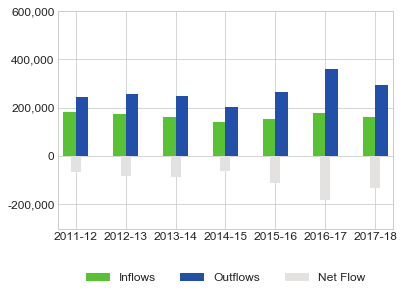

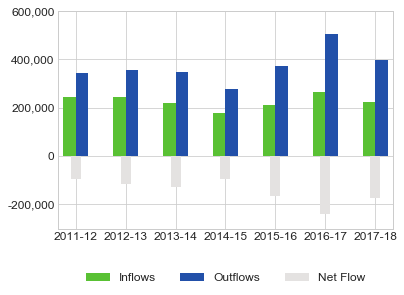

In [23]:
# plot each
pl1=plot_migration(total_city_dom, wccolors)
f=pl1.get_figure()
f.savefig(os.path.join(out_path, 'images','nyc_flows_yrly.png'),bbox_inches='tight')

pl2=plot_migration(total_metro_dom, wccolors)
f2=pl2.get_figure()
f2.savefig(os.path.join(out_path, 'images','nyma_flows_yrly.png'),bbox_inches='tight')

In [24]:
# put cummulative in one table 
cum_mig=pd.concat([total_city_dom.sum(),total_metro_dom.sum()], axis=1)
cum_mig.columns=['domestic_mig_nyc','domestic_mig_nyma']
cum_mig

,domestic_mig_nyc,domestic_mig_nyma
in_migration,"1,150,518","1,592,814"
out_migration,"1,873,856","2,601,002"
net_migration,"-723,338","-1,008,188"


In [25]:
# format the table for output into latex document
cum_mig_latex=cum_mig[['domestic_mig_nyc','domestic_mig_nyma']].T
cum_mig_latex.rename(index={'domestic_mig_nyc':'New York City','domestic_mig_nyma':'New York Metro'}, 
                     columns={'in_migration':'In Flows','out_migration':'Out Flows','net_migration':'Net Flow'},inplace=True)

cum_mig_latex

,In Flows,Out Flows,Net Flow
New York City,"1,150,518","1,873,856","-723,338"
New York Metro,"1,592,814","2,601,002","-1,008,188"


In [26]:
cum_mig_latex.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  In Flows &  Out Flows &   Net Flow \\\\\n\\midrule\nNew York City  & 1,150,518 &  1,873,856 &   -723,338 \\\\\nNew York Metro & 1,592,814 &  2,601,002 & -1,008,188 \\\\\n\\bottomrule\n\\end{tabular}\n'

## NYC Inflows, Outflows, Netflows

In [27]:
# Inflows to NYC
domestic_city_flows.loc[~domestic_city_flows.index.isin(suppressed),['co_name','tot_inflow']].sort_values('tot_inflow', ascending=False).head(n=20)

,co_name,tot_inflow
co_fips,,
36059,"Nassau County, NY","96,622"
36119,"Westchester County, NY","72,710"
36103,"Suffolk County, NY","50,090"
34017,"Hudson County, NJ","40,860"
34003,"Bergen County, NJ","30,801"
06037,"Los Angeles County, CA","30,314"
09001,"Fairfield County, CT","24,268"
34013,"Essex County, NJ","22,038"
12086,"Miami-Dade County, FL","19,382"


In [28]:
# Outflows from NYC
domestic_city_flows.loc[~domestic_city_flows.index.isin(suppressed),['co_name','tot_outflow']].sort_values('tot_outflow', ascending=False).head(n=20)

,co_name,tot_outflow
co_fips,,
36059,"Nassau County, NY","185,667"
36119,"Westchester County, NY","130,410"
36103,"Suffolk County, NY","71,696"
34017,"Hudson County, NJ","69,230"
34003,"Bergen County, NJ","56,269"
06037,"Los Angeles County, CA","51,895"
34013,"Essex County, NJ","45,641"
09001,"Fairfield County, CT","42,041"
34023,"Middlesex County, NJ","30,764"


In [29]:
# Net senders to NYC (NYC gains migrants)
domestic_city_flows.loc[~domestic_city_flows.index.isin(suppressed),['co_name','tot_netflow']].sort_values('tot_netflow', ascending=False).head(n=20)

,co_name,tot_netflow
co_fips,,
11001,"District of Columbia, DC","2,922"
25025,"Suffolk County, MA","1,153"
25017,"Middlesex County, MA",604
36109,"Tompkins County, NY",369
51013,"Arlington County, VA",278
49049,"Utah County, UT",267
12073,"Leon County, FL",248
17019,"Champaign County, IL",202
42027,"Centre County, PA",175


In [30]:
# Net receivers from NYC (NYC loses migrants)
domestic_city_flows.loc[~domestic_city_flows.index.isin(suppressed),['co_name','tot_netflow']].sort_values('tot_netflow', ascending=True).head(n=20)

,co_name,tot_netflow
co_fips,,
36059,"Nassau County, NY","-89,045"
36119,"Westchester County, NY","-57,700"
34017,"Hudson County, NJ","-28,370"
34003,"Bergen County, NJ","-25,468"
34013,"Essex County, NJ","-23,603"
36103,"Suffolk County, NY","-21,606"
06037,"Los Angeles County, CA","-21,581"
09001,"Fairfield County, CT","-17,773"
36071,"Orange County, NY","-16,047"


In [31]:
# Summary of other flows
domestic_city_flows.loc[domestic_city_flows.index.isin(suppressed),['co_name','tot_inflow','tot_outflow','tot_netflow']].sort_values('tot_netflow', ascending=True)

,co_name,tot_inflow,tot_outflow,tot_netflow
co_fips,,,,
59000,Other flows - Different State,"129,062","159,730","-30,668"
58000,Other flows - Same State,"8,152","9,396","-1,244"


In [32]:
#Get list of top inflow and outflow counties
top_inflows=domestic_city_flows['tot_inflow'].sort_values(ascending=False).head(n=17).drop('59000')
top_outflows=domestic_city_flows['tot_outflow'].sort_values(ascending=False).head(n=17).drop('59000')
counties_for_plot=top_inflows.index.tolist()
counties_for_plot.extend(top_outflows.index.tolist())
counties_for_plot=set(counties_for_plot)
len(counties_for_plot)

20

In [33]:
df_to_plot=domestic_city_flows.loc[counties_for_plot,['co_name','tot_inflow','tot_outflow']]
df_to_plot.sort_values(by='tot_outflow',ascending=False, inplace=True)
df_to_plot

,co_name,tot_inflow,tot_outflow
co_fips,,,
36059,"Nassau County, NY","96,622","185,667"
36119,"Westchester County, NY","72,710","130,410"
36103,"Suffolk County, NY","50,090","71,696"
34017,"Hudson County, NJ","40,860","69,230"
34003,"Bergen County, NJ","30,801","56,269"
06037,"Los Angeles County, CA","30,314","51,895"
34013,"Essex County, NJ","22,038","45,641"
09001,"Fairfield County, CT","24,268","42,041"
34023,"Middlesex County, NJ","16,857","30,764"


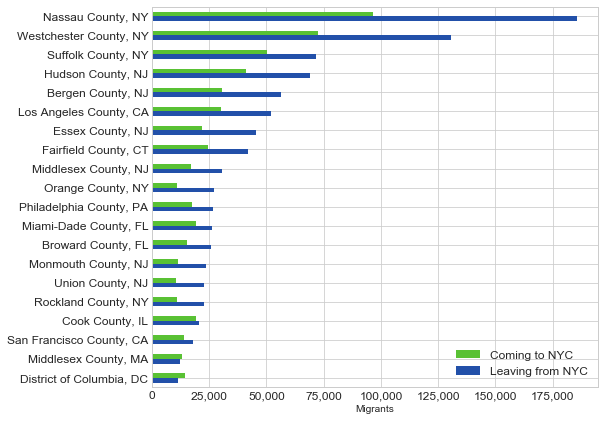

In [34]:
#Inflows and outflows on one chart
axc=df_to_plot.set_index('co_name').plot(kind='barh',figsize=(8,7), color=wccolors)
axc.legend(['Coming to NYC','Leaving from NYC'], loc='best',fontsize=12, frameon=False)
axc.invert_yaxis()
axc.set_ylabel('')
axc.set_xlabel('Migrants')
axc.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# ticks labels size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
nyc_fig=axc.get_figure()
nyc_fig.savefig(os.path.join(out_path, 'images','nyc_top_flows.png'),bbox_inches='tight')

## Functions for Showing Changes in Ranking Over Time

In [35]:
# Create array of top N geographies by flow type, with rows as ranks and columns as years
# Returns 3 arrays with values for geographies (id codes), flow values, and place names
# Must specify: number of places to rank, counties or metros, or sort by largest or smallest (True or False)
def create_arrays(df,flowtype,nsize,gtype,largest):
    geogs=[]
    flows=[]
    cols=[c for c in df if c.startswith(flowtype)]
    for c in cols:
        if gtype=='counties':
            row=df.loc[~df.index.isin(suppressed),[c]]
        elif gtype=='metros':
            row=df.loc[~df.index.isin(msuppressed),[c]]   
        if largest is True:
            row=row[c].nlargest(nsize)
        elif largest is False:
            row=row[c].nsmallest(nsize)
        idxs=list(row.index)
        geogs.append(idxs)
        vals=list(row.values)
        flows.append(vals)
    
    if gtype=='counties':
        fips=df.to_dict()['co_name']
    elif gtype=='metros':
        fips=df.to_dict()['mname']
    labels=[]
    for row in geogs:
        line=[]
        for uid in row:
            if gtype=='counties':
                if fips[uid]=='District of Columbia, DC':
                    line.append('Washington\n DC')
                else:
                    line.append(fips[uid].replace('County, ','\n')) #creates short labels
            elif gtype=='metros':
                if '-' in fips[uid]:
                    line.append(fips[uid].split('-')[0]) #creates short labels
                else:
                    line.append(fips[uid].split(',')[0])
        labels.append(line)
        
    a_geogs=np.array(geogs).T
    a_flows=np.array(flows).T
    a_labels=np.array(labels).T

    return a_geogs, a_flows, a_labels

In [36]:
# Create array showing how top N geographies have changed ranks over time, with rows as rank changes and 
# columns as years. Returns 1 array with values: 0 (no change), 1 (increased rank), and -1 (descreased rank)
def rank_change(geoarray):
    rowcount=geoarray.shape[0]
    colcount=geoarray.shape[1]

    # Create a number of blank lists
    changelist = [[] for _ in range(rowcount)]

    for i in range(colcount):
        if i==0:
            # Rank change for 1st year is 0, as there is no previous year
            for j in range(rowcount):
                changelist[j].append(0)
        else:
            col=geoarray[:,i] #Get all values in this col
            prevcol=geoarray[:,i-1] #Get all values in previous col
            for v in col:
                array_pos=np.where(col == v) #returns array
                current_pos=int(array_pos[0]) #get first array value
                array_pos2=np.where(prevcol == v) #returns array
                if len(array_pos2[0])==0: #if array is empty, because place was not in previous year
                    previous_pos=current_pos+1
                else:
                    previous_pos=int(array_pos2[0]) #get first array value
                if current_pos==previous_pos:
                    changelist[current_pos].append(0)
                    #print('Processed',v, current_pos)
                    #print('No change in rank for',v)
                elif current_pos<previous_pos: #Smaller value = higher rank
                    changelist[current_pos].append(1)
                    #print('Processed',v, current_pos)
                    #print('Rank has increased for',v)
                elif current_pos>previous_pos: #Larger value = smaller rank
                    changelist[current_pos].append(-1)
                    #print('Processed',v, current_pos)
                    #print('Rank has decreased for',v)
                else:
                    pass

    rankchange=np.array(changelist)                 
    return rankchange

In [37]:
# Create grid plot based on an array that shows change in ranks and an array of cell labels
def rank_grid(rank_change,labels):
    alabels=labels
    xlabels=[yr.replace('_','-') for yr in years]
    ranklabels=['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th',
               '11th','12th','13th','14th','15th','16th','17th','18th','19th','20th']
    nsize=rank_change.shape[0]
    ylabels=ranklabels[:nsize]
    
    #mycolors = colors.ListedColormap(['lightblue','ghostwhite','palegreen'])
    mycolors = colors.ListedColormap(['#2250a9','#f8f8ff','#59c134'])


    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(rank_change, cmap=mycolors)

    # Show all ticks...
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_yticks(np.arange(len(ylabels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)

    # Create white grid.
    ax.set_xticks(np.arange(rank_change.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(rank_change.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.grid(which="major",visible=False)

    cbar = ax.figure.colorbar(im, ax=ax, ticks=[1,0,-1], shrink=0.5)
    cbar.ax.set_yticklabels(['Increased','No Change','Decreased'])

    # Loop over data dimensions and create text annotations.
    for i in range(len(ylabels)):
        for j in range(len(xlabels)):
            if rank_change[i,j] != 0:
                text = ax.text(j, i, alabels[i, j],
                           ha="center", va="center", color="w", fontsize=10)
            else:
                text = ax.text(j, i, alabels[i, j],
                           ha="center", va="center", color="k", fontsize=10)
                
    #ax.set_title("Change in Rank Over Time")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    fig.tight_layout()
    plt.show()
    return ax

## Changes in Rank - NYC Flows

In [38]:
#Create arrays for inflows
incounty_geogs, incounty_flows, incounty_labels = create_arrays(domestic_city_flows,'inflow',10,'counties',True)

In [39]:
incounty_geogs

array([['36059', '36059', '36059', '36059', '36059', '36059', '36059'],
       ['36119', '36119', '36119', '36119', '36119', '36119', '36119'],
       ['36103', '36103', '36103', '36103', '36103', '36103', '36103'],
       ['34017', '34017', '34017', '34017', '34017', '34017', '34017'],
       ['34003', '34003', '34003', '34003', '06037', '06037', '06037'],
       ['06037', '06037', '06037', '06037', '34003', '34003', '34003'],
       ['12086', '12086', '09001', '48453', '09001', '09001', '09001'],
       ['34013', '09001', '34013', '09001', '34013', '17031', '34013'],
       ['09001', '34013', '12086', '34013', '17031', '34013', '17031'],
       ['34023', '12011', '17031', '34023', '48453', '06075', '06075']],
      dtype='<U5')

In [40]:
#Create array for annual change in ranks
incounty_rchange=rank_change(incounty_geogs)
incounty_rchange

array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  1,  1,  1,  0,  0],
       [ 0,  1,  1, -1,  1,  1,  1],
       [ 0, -1, -1, -1,  1, -1, -1],
       [ 0,  1,  1,  1, -1,  1,  0]])

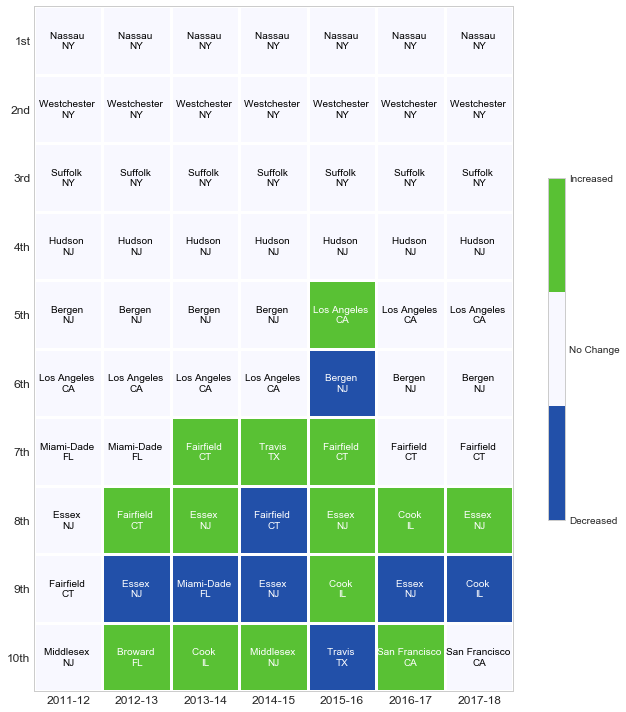

In [41]:
#Create grid for annual change in ranks for inflows
incounty_rankplot=rank_grid(incounty_rchange,incounty_labels)
inco_fig=incounty_rankplot.get_figure()
inco_fig.savefig(os.path.join(out_path, 'images','nyc_inflow_grid.png'),bbox_inches='tight')

In [42]:
#Create arrays for outflows
outcounty_geogs, outcounty_flows, outcounty_labels = create_arrays(domestic_city_flows,'outflow',10,'counties',True)

In [43]:
#Create array for annual change in ranks
outcounty_rchange=rank_change(outcounty_geogs)

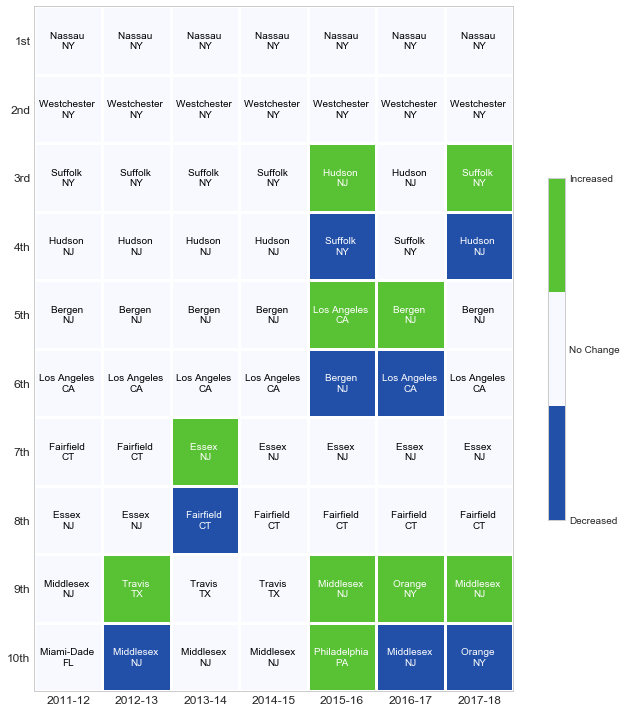

In [44]:
#Create grid for annual change in ranks for outflows
outcounty_rankplot=rank_grid(outcounty_rchange,outcounty_labels)
outco_fig=outcounty_rankplot.get_figure()
outco_fig.savefig(os.path.join(out_path, 'images','nyc_outflow_grid.png'),bbox_inches='tight')

In [45]:
#Create arrays for negative netflows (sort is False to go from small to large)
netcounty_geogs, netcounty_flows, netcounty_labels = create_arrays(domestic_city_flows,'netflow',10,'counties',False)

In [46]:
#Create array for annual change in ranks
netcounty_rchange=rank_change(netcounty_geogs)

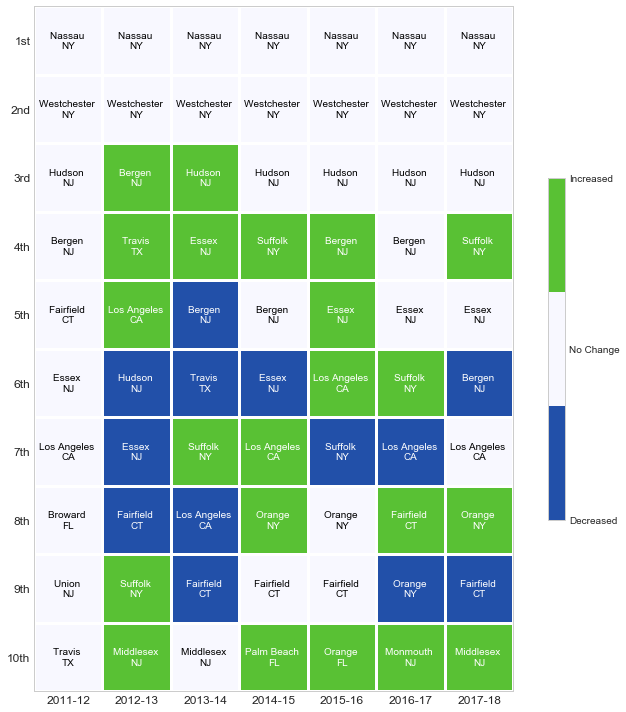

In [47]:
#Create grid for annual change in ranks for negative net flows
netcounty_rankplot=rank_grid(netcounty_rchange,netcounty_labels)
netco_fig=netcounty_rankplot.get_figure()
netco_fig.savefig(os.path.join(out_path, 'images','extras','nyc_netflow_grid.png'),bbox_inches='tight')

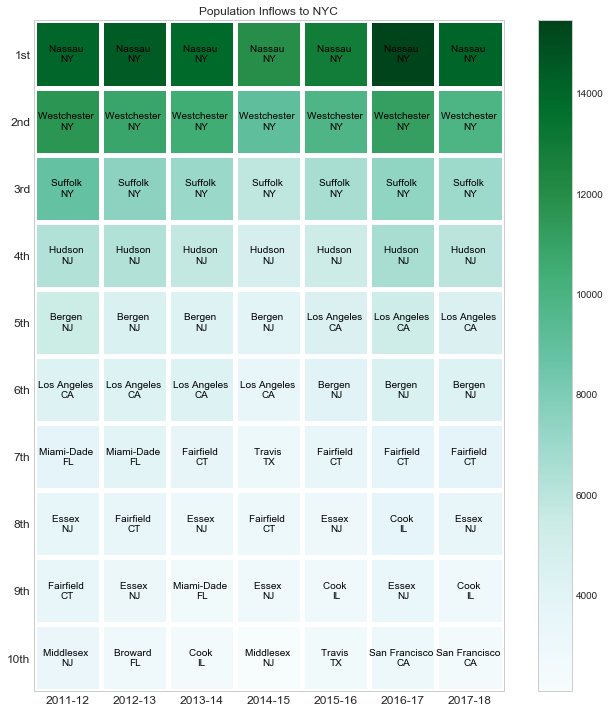

In [48]:
#Just a test to see grid of actual values
alabels=incounty_labels
ylabels=['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
xlabels=[yr.replace('_','-') for yr in years]

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(incounty_flows, cmap='BuGn')

# Show all ticks...
ax.set_xticks(np.arange(len(xlabels)))
ax.set_yticks(np.arange(len(ylabels)))
# ... and label them with the respective list entries
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

# Create white grid.
ax.set_xticks(np.arange(incounty_flows.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(incounty_flows.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=5)
ax.grid(which="major",visible=False)

cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data dimensions and create text annotations.
for i in range(len(ylabels)):
    for j in range(len(xlabels)):
        text = ax.text(j, i, alabels[i, j],
                       ha="center", va="center", color="k", fontsize=10)

ax.set_title("Population Inflows to NYC")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
plt.show()

## NYMA Inflows, Outflows, Netflows

In [49]:
# Inflows to NYMA
grouped_by_metro.loc[~grouped_by_metro.index.isin(msuppressed),['mname','tot_inflow']].sort_values('tot_inflow', ascending=False).head(n=20)

,mname,tot_inflow
mcode,,
37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","95,914"
33100,"Miami-Fort Lauderdale-Pompano Beach, FL","92,153"
47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV","63,730"
31080,"Los Angeles-Long Beach-Anaheim, CA","56,832"
14460,"Boston-Cambridge-Newton, MA-NH","53,223"
14860,"Bridgeport-Stamford-Norwalk, CT","50,082"
39100,"Poughkeepsie-Newburgh-Middletown, NY","50,002"
45940,"Trenton-Princeton, NJ","38,174"
16980,"Chicago-Naperville-Elgin, IL-IN-WI","34,771"


In [50]:
# Outflows to NYMA
grouped_by_metro.loc[~grouped_by_metro.index.isin(msuppressed),['mname','tot_outflow']].sort_values('tot_outflow', ascending=False).head(n=20)

,mname,tot_outflow
mcode,,
33100,"Miami-Fort Lauderdale-Pompano Beach, FL","161,220"
37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","143,776"
31080,"Los Angeles-Long Beach-Anaheim, CA","92,117"
14860,"Bridgeport-Stamford-Norwalk, CT","88,573"
39100,"Poughkeepsie-Newburgh-Middletown, NY","84,840"
47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV","81,548"
36740,"Orlando-Kissimmee-Sanford, FL","70,024"
12060,"Atlanta-Sandy Springs-Alpharetta, GA","68,485"
14460,"Boston-Cambridge-Newton, MA-NH","62,579"


In [51]:
# Net senders to NYMA (NYMA gains migrants)
grouped_by_metro.loc[~grouped_by_metro.index.isin(msuppressed),['mname','tot_netflow']].sort_values('tot_netflow', ascending=False).head(n=20)

,mname,tot_netflow
mcode,,
27060,"Ithaca, NY",630
45220,"Tallahassee, FL",374
44300,"State College, PA",324
39340,"Provo-Orem, UT",267
31540,"Madison, WI",206
16580,"Champaign-Urbana, IL",199
11460,"Ann Arbor, MI",195
30780,"Little Rock-North Little Rock-Conway, AR",153
14020,"Bloomington, IN",146


In [52]:
# Net receivers from NYMA (NYMA loses migrants)
grouped_by_metro.loc[~grouped_by_metro.index.isin(msuppressed),['mname','tot_netflow']].sort_values('tot_netflow', ascending=True).head(n=20)

,mname,tot_netflow
mcode,,
33100,"Miami-Fort Lauderdale-Pompano Beach, FL","-69,067"
37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","-47,862"
36740,"Orlando-Kissimmee-Sanford, FL","-43,301"
14860,"Bridgeport-Stamford-Norwalk, CT","-38,491"
12060,"Atlanta-Sandy Springs-Alpharetta, GA","-36,886"
31080,"Los Angeles-Long Beach-Anaheim, CA","-35,285"
39100,"Poughkeepsie-Newburgh-Middletown, NY","-34,838"
45300,"Tampa-St. Petersburg-Clearwater, FL","-32,616"
10900,"Allentown-Bethlehem-Easton, PA-NJ","-28,219"


In [53]:
grouped_by_metro.loc[grouped_by_metro.index.isin(msuppressed),['mname','tot_inflow','tot_outflow','tot_netflow']].sort_values('tot_netflow', ascending=True)

,mname,tot_inflow,tot_outflow,tot_netflow
mcode,,,,
59,Other flows - Different State,"437,112","564,810","-127,698"
0,non-metro,"8,278","14,929","-6,651"
58,Other flows - Same State,"20,349","23,219","-2,870"


In [54]:
mtop_inflows=grouped_by_metro['tot_inflow'].sort_values(ascending=False).head(n=20).drop('59').drop('58')
mtop_outflows=grouped_by_metro['tot_outflow'].sort_values(ascending=False).head(n=20).drop('59')
metros_for_plot=mtop_inflows.index.tolist()
metros_for_plot.extend(mtop_outflows.index.tolist())
metros_for_plot=set(metros_for_plot)
len(metros_for_plot)

19

In [55]:
df_to_plot=grouped_by_metro.loc[metros_for_plot,['mname','tot_inflow','tot_outflow']]
df_to_plot.sort_values(by='tot_outflow',ascending=False, inplace=True)
df_to_plot

,mname,tot_inflow,tot_outflow
mcode,,,
33100,"Miami-Fort Lauderdale-Pompano Beach, FL","92,153","161,220"
37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","95,914","143,776"
31080,"Los Angeles-Long Beach-Anaheim, CA","56,832","92,117"
14860,"Bridgeport-Stamford-Norwalk, CT","50,082","88,573"
39100,"Poughkeepsie-Newburgh-Middletown, NY","50,002","84,840"
47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV","63,730","81,548"
36740,"Orlando-Kissimmee-Sanford, FL","26,723","70,024"
12060,"Atlanta-Sandy Springs-Alpharetta, GA","31,599","68,485"
14460,"Boston-Cambridge-Newton, MA-NH","53,223","62,579"


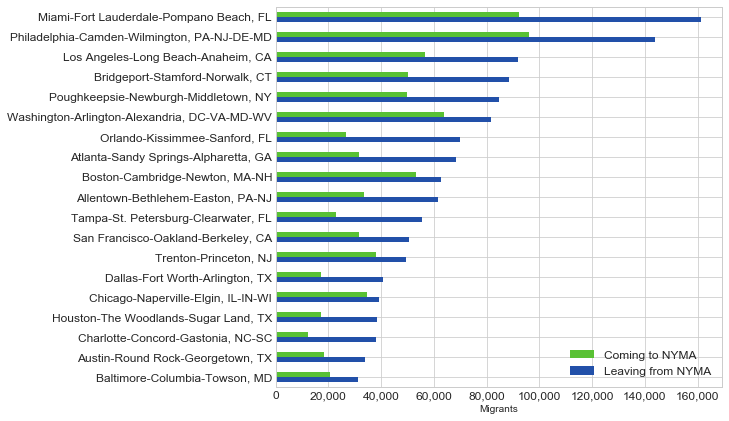

In [56]:
axm=df_to_plot.set_index('mname').plot(kind='barh',figsize=(8,7), color=wccolors)
axm.legend(['Coming to NYMA','Leaving from NYMA'], loc='best',fontsize=12, frameon=False)
axm.invert_yaxis()
axm.set_ylabel('')
axm.set_xlabel('Migrants')
axm.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# ticks labels size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
nyma_fig=axm.get_figure()
nyma_fig.savefig(os.path.join(out_path, 'images','nyma_top_flows.png'),bbox_inches='tight')

## Changes in Rank - NYMA Flows

In [57]:
#Create arrays for inflows
inmetro_geogs, inmetro_flows, inmetro_labels = create_arrays(grouped_by_metro,'inflow',10,'metros',True)

In [58]:
inmetro_geogs

array([['33100', '33100', '37980', '37980', '37980', '37980', '37980'],
       ['37980', '37980', '33100', '33100', '33100', '33100', '33100'],
       ['47900', '47900', '31080', '47900', '47900', '47900', '47900'],
       ['31080', '31080', '47900', '31080', '31080', '31080', '31080'],
       ['14460', '14460', '14860', '14860', '14860', '14460', '14460'],
       ['39100', '39100', '39100', '39100', '14460', '39100', '14860'],
       ['14860', '14860', '14460', '12420', '39100', '14860', '39100'],
       ['12060', '12060', '45940', '14460', '45940', '45940', '41860'],
       ['10900', '45940', '16980', '45940', '16980', '41860', '45940'],
       ['45940', '10900', '12060', '10900', '12420', '16980', '16980']],
      dtype='<U5')

In [59]:
#Create array for annual change in ranks
inmetro_rchange=rank_change(inmetro_geogs)
inmetro_rchange

array([[ 0,  0,  1,  0,  0,  0,  0],
       [ 0,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  1,  1,  0,  0,  0],
       [ 0,  0, -1, -1,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  1,  1,  1],
       [ 0,  0, -1,  1, -1, -1, -1],
       [ 0,  0,  1, -1,  1,  0,  1],
       [ 0,  1,  1, -1,  1,  1, -1],
       [ 0, -1, -1,  1, -1, -1,  0]])

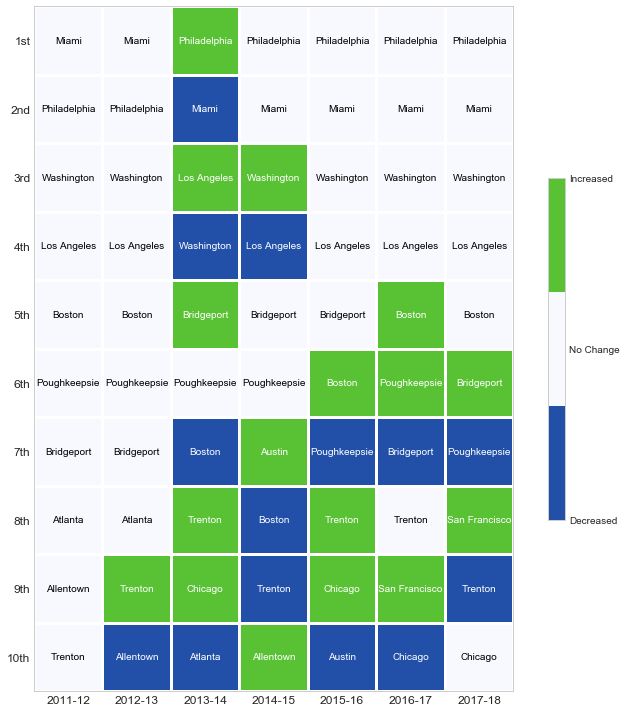

In [60]:
#Create grid for annual change in ranks for inflows
inmetro_rankplot=rank_grid(inmetro_rchange,inmetro_labels)
inmet_fig=inmetro_rankplot.get_figure()
inmet_fig.savefig(os.path.join(out_path, 'images','nyma_inflow_grid.png'),bbox_inches='tight')

In [61]:
#Create arrays for outflows
outmetro_geogs, outmetro_flows, outmetro_labels = create_arrays(grouped_by_metro,'outflow',10,'metros',True)

In [62]:
#Create array for annual change in ranks
outmetro_rchange=rank_change(outmetro_geogs)

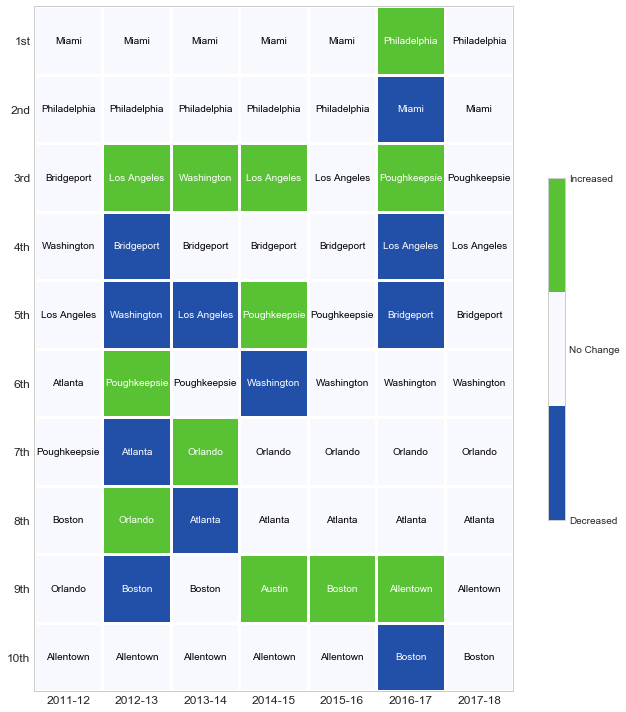

In [63]:
#Create grid for annual change in ranks for outflows
outmetro_rankplot=rank_grid(outmetro_rchange,outmetro_labels)
outmet_fig=outmetro_rankplot.get_figure()
outmet_fig.savefig(os.path.join(out_path, 'images','nyma_outflow_grid.png'),bbox_inches='tight')

In [64]:
#Create arrays for netflows
netmetro_geogs, netmetro_flows, netmetro_labels = create_arrays(grouped_by_metro,'netflow',10,'metros',False)

In [65]:
#Create array for annual change in ranks
netmetro_rchange=rank_change(netmetro_geogs)

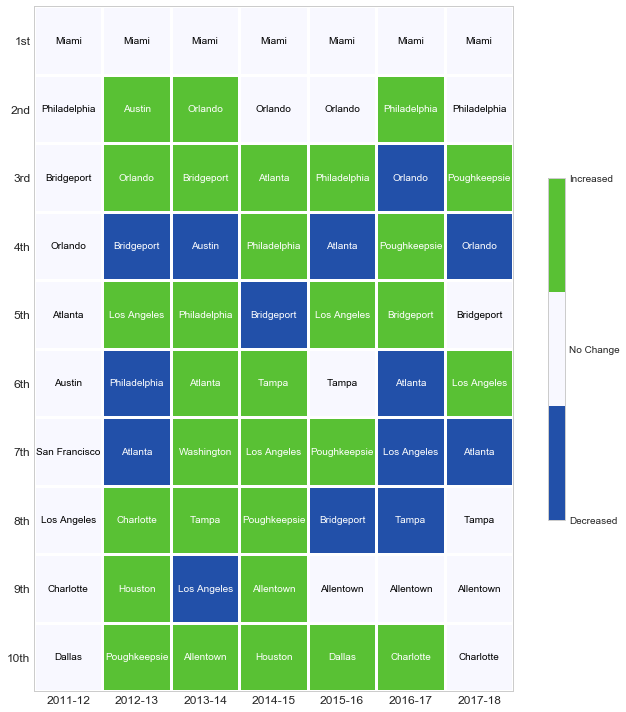

In [66]:
#Create grid for annual change in ranks for netflows
netmetro_rankplot=rank_grid(netmetro_rchange,netmetro_labels)
netmet_fig=netmetro_rankplot.get_figure()
netmet_fig.savefig(os.path.join(out_path, 'images','extras','nyma_netflow_grid.png'),bbox_inches='tight')

## Net Totals Tables

In [67]:
domestic_city_flows.sort_values(by='tot_netflow',inplace=True)
citytop20net=domestic_city_flows[domestic_city_flows.index != '59000'][['co_name','tot_netflow']].head(n=20)
citytop20net.set_index('co_name',inplace=True)
print(citytop20net.to_latex())

\begin{tabular}{lr}
\toprule
{} &  tot\_netflow \\
co\_name                 &              \\
\midrule
Nassau County, NY       &      -89,045 \\
Westchester County, NY  &      -57,700 \\
Hudson County, NJ       &      -28,370 \\
Bergen County, NJ       &      -25,468 \\
Essex County, NJ        &      -23,603 \\
Suffolk County, NY      &      -21,606 \\
Los Angeles County, CA  &      -21,581 \\
Fairfield County, CT    &      -17,773 \\
Orange County, NY       &      -16,047 \\
Middlesex County, NJ    &      -13,907 \\
Union County, NJ        &      -12,318 \\
Monmouth County, NJ     &      -12,207 \\
Rockland County, NY     &      -11,638 \\
Broward County, FL      &      -10,643 \\
Orange County, FL       &      -10,369 \\
Palm Beach County, FL   &       -9,601 \\
Philadelphia County, PA &       -9,445 \\
Ocean County, NJ        &       -8,923 \\
Travis County, TX       &       -7,548 \\
Harris County, TX       &       -7,309 \\
\bottomrule
\end{tabular}



In [68]:
citybot10net=domestic_city_flows[['co_name','tot_netflow']].tail(n=10)
citybot10net.set_index('co_name',inplace=True)
citybot10net.sort_values(by='tot_netflow', ascending=False, inplace=True)
print(citybot10net.to_latex())

\begin{tabular}{lr}
\toprule
{} &  tot\_netflow \\
co\_name                  &              \\
\midrule
District of Columbia, DC &        2,922 \\
Suffolk County, MA       &        1,153 \\
Middlesex County, MA     &          604 \\
Tompkins County, NY      &          369 \\
Arlington County, VA     &          278 \\
Utah County, UT          &          267 \\
Leon County, FL          &          248 \\
Champaign County, IL     &          202 \\
Centre County, PA        &          175 \\
Washtenaw County, MI     &          173 \\
\bottomrule
\end{tabular}



In [69]:
grouped_by_metro.sort_values(by='tot_netflow',inplace=True)
metrotop20net=grouped_by_metro[grouped_by_metro.index != '59'][['mname','tot_netflow']].head(n=20)
metrotop20net.set_index('mname',inplace=True)
print(metrotop20net.to_latex())

\begin{tabular}{lr}
\toprule
{} &  tot\_netflow \\
mname                                         &              \\
\midrule
Miami-Fort Lauderdale-Pompano Beach, FL       &      -69,067 \\
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD   &      -47,862 \\
Orlando-Kissimmee-Sanford, FL                 &      -43,301 \\
Bridgeport-Stamford-Norwalk, CT               &      -38,491 \\
Atlanta-Sandy Springs-Alpharetta, GA          &      -36,886 \\
Los Angeles-Long Beach-Anaheim, CA            &      -35,285 \\
Poughkeepsie-Newburgh-Middletown, NY          &      -34,838 \\
Tampa-St. Petersburg-Clearwater, FL           &      -32,616 \\
Allentown-Bethlehem-Easton, PA-NJ             &      -28,219 \\
Charlotte-Concord-Gastonia, NC-SC             &      -25,914 \\
Dallas-Fort Worth-Arlington, TX               &      -23,785 \\
Houston-The Woodlands-Sugar Land, TX          &      -21,431 \\
Raleigh-Cary, NC                              &      -19,017 \\
San Francisco-Oakland-Berkeley, CA          

In [70]:
metrobot10net=grouped_by_metro[['mname','tot_netflow']].tail(n=10)
metrobot10net.set_index('mname',inplace=True)
metrobot10net.sort_values(by='tot_netflow', ascending=False, inplace=True)
print(metrobot10net.to_latex())

\begin{tabular}{lr}
\toprule
{} &  tot\_netflow \\
mname                                    &              \\
\midrule
Ithaca, NY                               &          630 \\
Tallahassee, FL                          &          374 \\
State College, PA                        &          324 \\
Provo-Orem, UT                           &          267 \\
Madison, WI                              &          206 \\
Champaign-Urbana, IL                     &          199 \\
Ann Arbor, MI                            &          195 \\
Little Rock-North Little Rock-Conway, AR &          153 \\
Bloomington, IN                          &          146 \\
Charlottesville, VA                      &          144 \\
\bottomrule
\end{tabular}



## Flows between NYC, suburban counties, and outside areas

In [71]:
# function to label counties in metro as 'suburban' and others as 'distant'
def is_suburban(col, metro):
    if col in metro:
        return 'suburban'
    else:
        return 'distant'

In [72]:
domestic_city_flows['cnty_status']=domestic_city_flows.apply(lambda row: 'suburban' if row.name in nyma else 'distant', axis=1)
domestic_city_flows['cnty_status'].value_counts()

distant    460
suburban    18
Name: cnty_status, dtype: int64

In [73]:
incols=[c for c in domestic_city_flows.columns if c.startswith('inflow')]
outcols=[c for c in domestic_city_flows.columns if c.startswith('outflow')]
all_cols=['cnty_status']+incols+outcols
by_status=domestic_city_flows[all_cols].groupby('cnty_status').sum()
by_status['tot_inflow']=by_status[incols].sum(axis=1)
by_status['tot_outflow']=by_status[outcols].sum(axis=1)
by_status['tot_netflow']=by_status['tot_inflow']-by_status['tot_outflow']
by_status

,inflow2011_12,inflow2012_13,inflow2013_14,inflow2014_15,inflow2015_16,inflow2016_17,inflow2017_18,outflow2011_12,outflow2012_13,outflow2013_14,outflow2014_15,outflow2015_16,outflow2016_17,outflow2017_18,tot_inflow,tot_outflow,tot_netflow
cnty_status,,,,,,,,,,,,,,,,,
distant,"117,478","115,168","105,707","91,814","100,791","118,956","106,935","155,147","161,670","154,740","126,574","166,241","220,222","176,213","756,849","1,160,807","-403,958"
suburban,"62,981","58,645","56,045","48,583","51,640","59,697","56,078","90,739","95,386","92,667","75,690","99,650","140,915","118,002","393,669","713,049","-319,380"


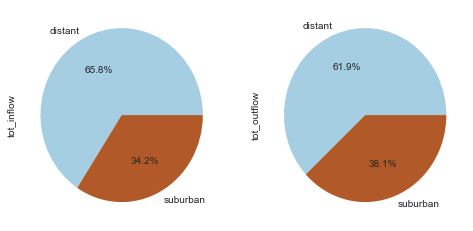

In [74]:
# inflows and outflows to NYC from suburban counties accounted for more than third of all domestic NYC flows 
ax=by_status[['tot_inflow','tot_outflow']].plot.pie(subplots=True, legend=False, autopct='%1.1f%%',figsize=(8,4),colormap='Paired')

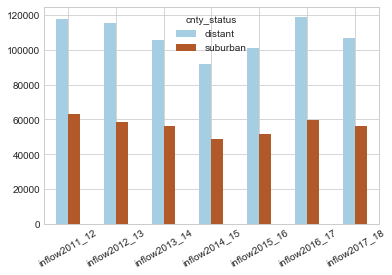

In [75]:
# Inflows to NYC by year
by_status[incols].T.plot(kind='bar', rot=30, colormap='Paired')

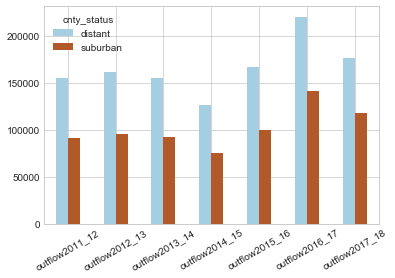

In [76]:
# Outflows from NYC by year
by_status[outcols].T.plot(kind='bar', rot=30, colormap='Paired')

## Comparison with other big cities and metros

Compare cumulative flows for selected big (population over 1M ) cities

In [77]:
# empty list to hold the records of the dataframe we'll build from querying the database
df_lines=[]

In [78]:
# get cumulative total domestic inflows and outflows for big cities
for cnty in big_cities.keys():
    
    # exclude NYC: it consists of multiple counties and we already have the data
    if cnty not in nyc:        
        # yearly outflows
        all_outs=[]        
        # yearly inflows
        all_ins=[]        
        for year in years:
            table1 = 'outflow_{}'.format (year)
            table2 = 'inflow_{}'.format (year)

            cur.execute("SELECT SUM (exemptions) as outflow{0} from {1} where {2}.origin='{3}' and {4}.destination!='{5}' and {6}.destination not in {7} ".format (year, table1,  table1, cnty, table1, cnty, table1, foreign))    
            outs=cur.fetchone()[0]

            cur.execute("SELECT SUM (exemptions) as inflow{0} from {1} where {2}.origin!='{3}' and {4}.destination='{5}' and {6}.origin not in {7} ".format (year, table2, table2, cnty, table2, cnty, table2, foreign))    
            ins=cur.fetchone()[0]
            
            all_outs.append(outs)
            all_ins.append(ins)
        # sum yearly data
        total_out=sum(all_outs)
        total_in=sum(all_ins)
        df_line=(cnty,total_in,total_out)
        df_lines.append(df_line)

In [79]:
# create a dataframe from the list 
df_cities=pd.DataFrame(df_lines, columns=['county','tot_inflow','tot_outflow'])
df_cities['tot_netflow']=df_cities['tot_inflow']-df_cities['tot_outflow']

In [80]:
# add city names column
city_names=pd.DataFrame.from_dict(big_cities, orient='index')
df_cities=df_cities.merge(city_names, left_on='county', right_index=True, how='left').rename(columns={0:'city_name'})

In [81]:
# append NYC records
nyc_tot=pd.DataFrame(domestic_city_flows[['tot_inflow','tot_outflow','tot_netflow']].sum()).T
nyc_tot['city_name']='New York City, NY'
df_cities=df_cities.append(nyc_tot)

In [82]:
# reorder columns; remove county column
df_cities=df_cities[['city_name','tot_inflow','tot_outflow','tot_netflow']]
df_cities.sort_values(by='tot_netflow',ascending=False, inplace=True)
df_cities

,city_name,tot_inflow,tot_outflow,tot_netflow
3,"Maricopa Co, AZ (Phoenix)","1,057,753","876,468","181,285"
5,"Bexar Co, TX (San Antonio)","554,313","495,341","58,972"
2,"Harris Co, TX (Houston)","1,140,861","1,204,817","-63,956"
7,"Dallas Co, TX","849,630","916,209","-66,579"
6,"San Diego Co, CA","795,260","863,590","-68,330"
4,"Philadelphia Co, PA","317,213","406,107","-88,894"
8,"Santa Clara Co, CA (San Jose)","450,721","568,066","-117,345"
1,"Cook Co, IL (Chicago)","874,722","1,224,927","-350,205"
0,"Los Angeles Co, CA","1,381,584","1,828,981","-447,397"
0,"New York City, NY","1,150,518","1,873,856","-723,338"


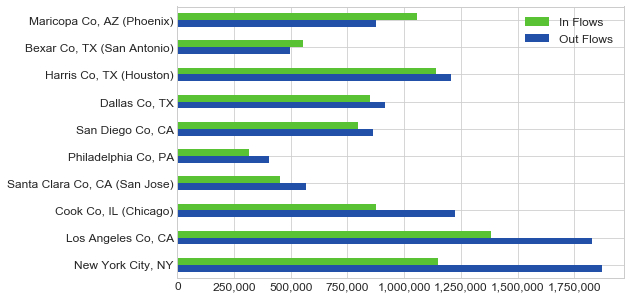

In [83]:
# plot domestic migration for 10 big cities
axbc=df_cities[['city_name','tot_inflow','tot_outflow']].set_index('city_name').plot(kind='barh', figsize=(8,5), color=wccolors)
axbc.legend(['In Flows','Out Flows'], fontsize=12, frameon=False)
axbc.invert_yaxis()              
axbc.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
axbc.set_ylabel('')
# ticks labels size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
big_c_fig=axbc.get_figure()
big_c_fig.savefig(os.path.join(out_path, 'images','extras','big_cities_flows.png'),bbox_inches='tight')

Compare cumulative flows for selected largest metros

In [84]:
mdf_lines=[]

In [85]:
# running this cell takes awhile
import time
start = time.time()

for m in big_metros:
    all_outs=[]
    all_ins=[]
    for year in years:
        
        table1 = 'outflow_{}'.format (year)
        table2 = 'inflow_{}'.format (year)
        
        outflows=pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table1, table1, table1), con)
        
        outflows=outflows.merge(metros[['mcode', 'mname', 'ccode']], left_on='origin', right_on='ccode',
                                   how='left').drop ('ccode', 1).rename(columns={'mname':'mname_orig',
                                                                                'mcode':'mcode_orig'})
        outflows=outflows.merge(metros[['mcode', 'mname', 'ccode']], left_on='destination', right_on='ccode',
                                   how='left').drop ('ccode', 1).rename(columns={'mname':'mname_dest',
                                                                                'mcode':'mcode_dest'})
        
        inflows=pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table2, table2, table2), con)
        
        inflows=inflows.merge(metros[['mcode', 'mname', 'ccode']], left_on='origin', right_on='ccode',
                                   how='left').drop ('ccode', 1).rename(columns={'mname':'mname_orig',
                                                                                'mcode':'mcode_orig'})
        inflows=inflows.merge(metros[['mcode', 'mname', 'ccode']], left_on='destination', right_on='ccode',
                                   how='left').drop ('ccode', 1).rename(columns={'mname':'mname_dest',
                                                                                'mcode':'mcode_dest'})
        
        # select & sum flows from counties that are not in the same metro and are not foreign
        tot_out=outflows.loc[(outflows['mcode_orig']==m) & (outflows['mcode_dest']!=m) & (~outflows['destination'].isin(foreign)), 'exemptions'].sum()
        
        # select & sum flows to metro from counties that are not in the same metro and are not foreign
        tot_in=inflows.loc[(inflows['mcode_orig']!=m) & (inflows['mcode_dest']==m) & (~inflows['origin'].isin(foreign)), 'exemptions'].sum()
        
        all_outs.append(tot_out)
        all_ins.append(tot_in)
        
    total_out=sum(all_outs)
    total_in=sum(all_ins)
    df_line=(m,total_in,total_out)
    mdf_lines.append(df_line)
    
end = time.time()
print(int(end - start), 'seconds passed')

101 seconds passed


In [86]:
mdf_lines

[('35620', 1592814.0, 2601002.0),
 ('31080', 1646413.0, 2165662.0),
 ('16980', 981499.0, 1390289.0),
 ('19100', 1517908.0, 1228907.0),
 ('26420', 1226126.0, 1031959.0),
 ('47900', 1298600.0, 1459732.0),
 ('33100', 1023229.0, 1173300.0),
 ('37980', 761484.0, 860254.0),
 ('12060', 1376434.0, 1219202.0),
 ('38060', 1079198.0, 852295.0),
 ('14460', 709090.0, 826530.0),
 ('41860', 965639.0, 1032336.0),
 ('40140', 1142343.0, 1025256.0),
 ('19820', 518550.0, 587585.0)]

In [87]:
df_metros=pd.DataFrame(mdf_lines, columns=['mcode','tot_inflow','tot_outflow'])
df_metros['tot_netflow']=df_metros['tot_inflow']-df_metros['tot_outflow']
df_metros

,mcode,tot_inflow,tot_outflow,tot_netflow
0,35620,"1,592,814","2,601,002","-1,008,188"
1,31080,"1,646,413","2,165,662","-519,249"
2,16980,"981,499","1,390,289","-408,790"
3,19100,"1,517,908","1,228,907","289,001"
4,26420,"1,226,126","1,031,959","194,167"
5,47900,"1,298,600","1,459,732","-161,132"
6,33100,"1,023,229","1,173,300","-150,071"
7,37980,"761,484","860,254","-98,770"
8,12060,"1,376,434","1,219,202","157,232"
9,38060,"1,079,198","852,295","226,903"


In [88]:
# add metro names to cbsa codes and merge
metro_names=metros[['mname','mcode']].drop_duplicates()
df_metros=df_metros.merge(metro_names, on='mcode')
df_metros.sort_values(by='tot_netflow', ascending=False, inplace=True)
df_metros

,mcode,tot_inflow,tot_outflow,tot_netflow,mname
3,19100,"1,517,908","1,228,907","289,001","Dallas-Fort Worth-Arlington, TX"
9,38060,"1,079,198","852,295","226,903","Phoenix-Mesa-Chandler, AZ"
4,26420,"1,226,126","1,031,959","194,167","Houston-The Woodlands-Sugar Land, TX"
8,12060,"1,376,434","1,219,202","157,232","Atlanta-Sandy Springs-Alpharetta, GA"
12,40140,"1,142,343","1,025,256","117,087","Riverside-San Bernardino-Ontario, CA"
11,41860,"965,639","1,032,336","-66,697","San Francisco-Oakland-Berkeley, CA"
13,19820,"518,550","587,585","-69,035","Detroit-Warren-Dearborn, MI"
7,37980,"761,484","860,254","-98,770","Philadelphia-Camden-Wilmington, PA-NJ-DE-MD"
10,14460,"709,090","826,530","-117,440","Boston-Cambridge-Newton, MA-NH"
6,33100,"1,023,229","1,173,300","-150,071","Miami-Fort Lauderdale-Pompano Beach, FL"


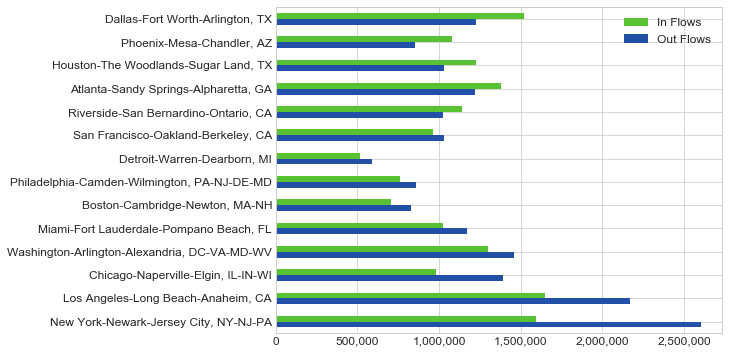

In [89]:
# plot domestic migration for big metros
axbm=df_metros[['mname','tot_inflow','tot_outflow']].set_index('mname').plot(kind='barh', figsize=(8,6), color=wccolors)
axbm.legend(['In Flows','Out Flows'], fontsize=12, frameon=False)
axbm.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
axbm.invert_yaxis() 
axbm.set_ylabel('')
# ticks labels size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
big_m_fig=axbm.get_figure()
big_m_fig.savefig(os.path.join(out_path, 'images','extras','big_metros_flows.png'),bbox_inches='tight')

## Other cities

Enter info for other counties / metros to check out their stats

In [91]:
other_county=['06037'] # LA county
other_metro=['06037','06059'] #LA metro

#other_county=['17031'] # Cook county IL
#other_metro=['17031','17037','17043','17063','17089','17093','17097','17111','17197',
#             '18073','18089','18111','18127','55059'] #Chicago metro

#other_county=['42101'] #Philly county
#other_metro=['10003','24015','34005','34007','34015','34033','42017','42029','42045',
#             '42091','42101'] #Philly metro

In [92]:
co_flows_dfs=[]
met_flows_dfs=[]

In [93]:
for year in years:
    co_flows_dfs.append (get_flows_by_city (year, other_county))

for year in years:
    met_flows_dfs.append (get_flows_by_city (year, other_metro))

# merge all years dfs from the list into a single df
co_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'mcode', 'mname'], how='outer'), co_flows_dfs)
met_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'mcode', 'mname'], how='outer'), met_flows_dfs)

In [94]:
co_flows.head()

,co_fips,co_name,state,inflow2011_12,outflow2011_12,mcode,mname,netflow2011_12,inflow2012_13,outflow2012_13,...,netflow2014_15,inflow2015_16,outflow2015_16,netflow2015_16,inflow2016_17,outflow2016_17,netflow2016_17,inflow2017_18,outflow2017_18,netflow2017_18
0,06059,"Orange County, CA",CA,"30,298","37,081",31080,"Los Angeles-Long Beach-Anaheim, CA","-6,783","32,180","37,902",...,"-4,827","27,833","35,765","-7,932","34,036","45,600","-11,564","27,374","36,837","-9,463"
1,06071,"San Bernardino County, CA",CA,"28,641","40,010",40140,"Riverside-San Bernardino-Ontario, CA","-11,369","27,414","39,172",...,"-11,047","20,116","37,393","-17,277","23,687","49,355","-25,668","20,850","41,482","-20,632"
2,06065,"Riverside County, CA",CA,"15,565","21,758",40140,"Riverside-San Bernardino-Ontario, CA","-6,193","14,967","22,447",...,"-5,518","11,135","20,479","-9,344","12,623","28,643","-16,020","10,815","23,567","-12,752"
3,06073,"San Diego County, CA",CA,"8,982","9,834",41740,"San Diego-Chula Vista-Carlsbad, CA",-852,"8,989","10,322",...,"-1,595","7,649","9,381","-1,732","9,444","11,685","-2,241","7,535","9,766","-2,231"
4,06111,"Ventura County, CA",CA,"8,593","10,502",37100,"Oxnard-Thousand Oaks-Ventura, CA","-1,909","8,195","11,280",...,"-1,727","7,399","10,776","-3,377","8,346","14,612","-6,266","7,083","11,729","-4,646"


In [95]:
# get subsets of domestic flows 
domestic_co_flows=co_flows[~co_flows['co_fips'].isin (foreign)].set_index('co_fips').copy()

#group by metro area to get metro to metro flows
met_flows=met_flows.groupby(['mname','mcode']).sum().reset_index()
met_flows=met_flows.set_index('mcode')

In [96]:
# add cummulative numbers for inflow, outflow, netflow for city and metro 
# these are totals for all years
domestic_co_flows['tot_inflow']=domestic_co_flows[[c for c in domestic_co_flows.columns if 
                                                       c.startswith('inflow')]].sum(axis=1)

domestic_co_flows['tot_outflow']=domestic_co_flows[[c for c in domestic_co_flows.columns if 
                                                       c.startswith('outflow')]].sum(axis=1)

domestic_co_flows['tot_netflow']=domestic_co_flows['tot_inflow']-domestic_co_flows['tot_outflow']

In [97]:
# annual domestic migration for county by year
total_co_dom=get_total_flows(domestic_co_flows)
total_co_dom

,in_migration,out_migration,net_migration
years,,,
2011_12,"211,644","252,314","-40,670"
2012_13,"212,627","261,257","-48,630"
2013_14,"193,376","245,689","-52,313"
2014_15,"157,365","197,551","-40,186"
2015_16,"188,147","254,455","-66,308"
2016_17,"229,735","340,934","-111,199"
2017_18,"188,690","276,781","-88,091"


In [98]:
domestic_co_flows.loc[~domestic_co_flows.index.isin(suppressed),['co_name','tot_inflow','tot_outflow','tot_netflow']].sort_values('tot_netflow', ascending=False).head(n=20)

,co_name,tot_inflow,tot_outflow,tot_netflow
co_fips,,,,
36061,"New York County, NY","25,200","15,921","9,279"
17031,"Cook County, IL","21,030","12,990","8,040"
36047,"Kings County, NY","16,266","8,525","7,741"
36081,"Queens County, NY","8,115","4,499","3,616"
25025,"Suffolk County, MA","4,175","2,440","1,735"
34017,"Hudson County, NJ","3,637","2,005","1,632"
25017,"Middlesex County, MA","5,976","4,360","1,616"
06075,"San Francisco County, CA","18,369","16,906","1,463"
42101,"Philadelphia County, PA","3,834","2,525","1,309"


In [99]:
domestic_co_flows.loc[~domestic_co_flows.index.isin(suppressed),['co_name','tot_inflow','tot_outflow','tot_netflow']].sort_values('tot_netflow', ascending=True).head(n=20)

,co_name,tot_inflow,tot_outflow,tot_netflow
co_fips,,,,
06071,"San Bernardino County, CA","163,681","273,400","-109,719"
06065,"Riverside County, CA","88,663","152,573","-63,910"
06059,"Orange County, CA","204,063","256,951","-52,888"
32003,"Clark County, NV","37,664","76,006","-38,342"
06111,"Ventura County, CA","53,476","76,841","-23,365"
06029,"Kern County, CA","29,832","45,915","-16,083"
04013,"Maricopa County, AZ","25,627","39,633","-14,006"
06073,"San Diego County, CA","57,443","68,104","-10,661"
48085,"Collin County, TX","2,958","9,055","-6,097"


In [100]:
met_flows['tot_inflow']=met_flows[[c for c in met_flows.columns if 
                                                       c.startswith('inflow')]].sum(axis=1)

met_flows['tot_outflow']=met_flows[[c for c in met_flows.columns if 
                                                       c.startswith('outflow')]].sum(axis=1)

met_flows['tot_netflow']=met_flows['tot_inflow']-met_flows['tot_outflow']

In [101]:
# annual domestic migration for metro by year
total_met_dom=get_total_flows(met_flows)
total_met_dom

,in_migration,out_migration,net_migration
years,,,
2011_12,"251,730","292,514","-40,784"
2012_13,"252,253","307,376","-55,123"
2013_14,"229,651","289,383","-59,732"
2014_15,"183,600","230,591","-46,991"
2015_16,"225,079","302,225","-77,146"
2016_17,"278,311","412,448","-134,137"
2017_18,"225,789","331,125","-105,336"


In [102]:
met_flows.loc[~met_flows.index.isin(msuppressed),['mname','tot_inflow','tot_outflow','tot_netflow']].sort_values('tot_netflow', ascending=False).head(n=20)

,mname,tot_inflow,tot_outflow,tot_netflow
mcode,,,,
35620,"New York-Newark-Jersey City, NY-NJ-PA","92,117","56,832","35,285"
16980,"Chicago-Naperville-Elgin, IL-IN-WI","38,735","25,191","13,544"
14460,"Boston-Cambridge-Newton, MA-NH","18,983","13,628","5,355"
37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","14,020","9,747","4,273"
47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV","28,420","24,530","3,890"
33100,"Miami-Fort Lauderdale-Pompano Beach, FL","21,102","18,719","2,383"
12580,"Baltimore-Columbia-Towson, MD","6,911","5,370","1,541"
14860,"Bridgeport-Stamford-Norwalk, CT","3,878","2,797","1,081"
19820,"Detroit-Warren-Dearborn, MI","8,950","7,988",962


In [103]:
met_flows.loc[~met_flows.index.isin(msuppressed),['mname','tot_inflow','tot_outflow','tot_netflow']].sort_values('tot_netflow', ascending=True).head(n=20)

,mname,tot_inflow,tot_outflow,tot_netflow
mcode,,,,
40140,"Riverside-San Bernardino-Ontario, CA","376,083","596,864","-220,781"
29820,"Las Vegas-Henderson-Paradise, NV","48,888","94,968","-46,080"
19100,"Dallas-Fort Worth-Arlington, TX","26,429","51,732","-25,303"
37100,"Oxnard-Thousand Oaks-Ventura, CA","60,616","83,273","-22,657"
38060,"Phoenix-Mesa-Chandler, AZ","40,513","62,342","-21,829"
12540,"Bakersfield, CA","34,078","50,996","-16,918"
41740,"San Diego-Chula Vista-Carlsbad, CA","96,706","112,063","-15,357"
38900,"Portland-Vancouver-Hillsboro, OR-WA","14,527","27,983","-13,456"
12420,"Austin-Round Rock-Georgetown, TX","16,574","28,906","-12,332"
